Alpha Oumar DIALLO

Dans ce travail, nous allons implementer un système de recommandations sur le jeu de données Movies Lens100k.

Pour ce faire, nous allons utiliser plusieurs approches (SVD, knn_basic, knn_with_means et knn_with_zscore), visualiser les éventuelles différences de résultats entre ces différentes approches et utiliser les prédictions de ces approches pour recommander à des utilisateurs des films qu'ils n'auraient pas vus ou notés.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357245 sha256=af97bce175b283cb1a96820d0e01de2eda801a8285e15cdf21640b709f72e14e
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


# Bibiothèques

In [ ]:
from surprise import Dataset, Reader, KNNBasic, accuracy
from surprise.model_selection import cross_validate, train_test_split
import pandas as pd
import os
import pandas as pd
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import SVD
from surprise import SlopeOne
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV

# Chargement des données

In [ ]:
import pandas as pd
from surprise import Dataset

# Charger les données MovieLens 100k
data = Dataset.load_builtin('ml-100k')

# Convertir les données en DataFrame pandas
raw_ratings = data.raw_ratings
df = pd.DataFrame(raw_ratings, columns=['user_id', 'item_id', 'rating', 'timestamp'])

Dataset ml-100k could not be found. Do you want to download it? [Y/n] Y
Trying to download dataset from https://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k


In [ ]:
from surprise.model_selection import train_test_split

# Diviser les données en ensemble d'entraînement (80%) et de test (20%)
data_train, data_test = train_test_split(data, test_size=0.2, random_state=42)

In [ ]:
import os

csv_path = '/content/drive/MyDrive/100.csv'

# Enregistre le DataFrame en tant que fichier CSV
df.to_csv(csv_path, index=False)

# Afficher un message de confirmation
print(f"DataFrame enregistré en tant que fichier CSV à l'emplacement suivant : {csv_path}")

DataFrame enregistré en tant que fichier CSV à l'emplacement suivant : /content/drive/MyDrive/100.csv


In [ ]:
import pandas as pd

csv_path = '/content/drive/MyDrive/100.csv'

# Charger le fichier CSV dans un DataFrame pandas
df = pd.read_csv(csv_path)

# Visualisation

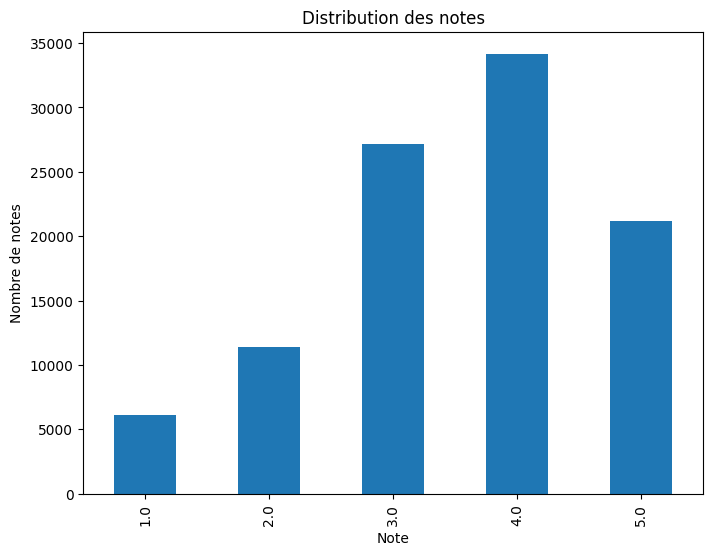

In [ ]:
import matplotlib.pyplot as plt

# Distribution des notes
plt.figure(figsize=(8, 6))
df['rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution des notes')
plt.xlabel('Note')
plt.ylabel('Nombre de notes')
plt.show()

## SVD classique

In [ ]:
from surprise import SVDpp,SVD
from surprise.accuracy import rmse,mae


# Définir le modèle
model_svd = SVD()

# Effectuer une validation croisée
cv_results = cross_validate(model_svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9305  0.9384  0.9411  0.9329  0.9399  0.9366  0.0041  
MAE (testset)     0.7323  0.7391  0.7413  0.7357  0.7423  0.7382  0.0037  
Fit time          1.62    3.12    2.37    2.40    4.41    2.78    0.94    
Test time         0.62    0.22    0.21    0.21    0.74    0.40    0.23    


## SVD avec optimisation des hyper paramètres

In [ ]:
%%time
import random

from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import GridSearchCV


# Load the full dataset.
data = Dataset.load_builtin('ml-100k')
raw_ratings = data.raw_ratings

# shuffle ratings if you want
random.shuffle(raw_ratings)

# A = 90% of the data, B = 10% of the data
threshold = int(.9 * len(raw_ratings))
A_raw_ratings = raw_ratings[:threshold]
B_raw_ratings = raw_ratings[threshold:]

data.raw_ratings = A_raw_ratings  # data is now the set A

# Select your best algo with grid search.
print('Grid Search...')
param_grid = {'n_epochs': [5,10,20,30,40,50], 'lr_all': [0.001, 0.005, 0.01, 0.05,0.5,1,0.08]}
grid_search = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=10) #tester plusieurs valeurs de cv
grid_search.fit(data)

algo = grid_search.best_estimator['rmse']

# retrain on the whole set A
trainset = data.build_full_trainset()
algo.fit(trainset)

# Compute biased accur  acy on A
predictions_train = algo.test(trainset.build_testset())
print('Biased accuracy on A,', end='   ')
accuracy.rmse(predictions_train)

# Compute unbiased accuracy on B
testset = data.construct_testset(B_raw_ratings)  # testset is now the set B
predictions_test = algo.test(testset)
print('Unbiased accuracy on B,', end=' ')
accuracy.rmse(predictions_test)

Grid Search...
Biased accuracy on A,   RMSE: 0.6840
Unbiased accuracy on B, RMSE: 0.9408
CPU times: user 11min 14s, sys: 3.61 s, total: 11min 18s
Wall time: 11min 23s


0.9408205396800996

## Prediction des notes

In [ ]:
import pandas as pd
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split

trainset = data.build_full_trainset()
algo.fit(trainset)

user_id = '186'
user_inner_id = trainset.to_inner_uid(user_id)

# Récupérer tous les items que l'utilisateur n'a pas notés
user_not_rated = trainset.build_anti_testset(fill=0)
user_not_rated = [item for item in user_not_rated if item[0] == trainset.to_raw_uid(user_inner_id)]

# Faire des prédictions pour ces items
predictions = [algo.predict(user_id, item[1], verbose=False) for item in user_not_rated]

# Trier les prédictions par score estimé dans un ordre décroissant
predictions.sort(key=lambda x: x.est, reverse=True)

# Extraire les top 10 recommandations
top_predictions = predictions[:10]

# Créer un DataFrame avec les résultats
top_movies_df = pd.DataFrame([(pred.iid, pred.est) for pred in top_predictions], columns=['Film ID', 'Score Prédit'])

In [ ]:
top_movies_df

,Film ID,Score Prédit
0,408,4.797009
1,178,4.623404
2,603,4.572648
3,318,4.557217
4,199,4.550348
5,489,4.530585
6,651,4.524597
7,320,4.524419
8,64,4.523665
9,483,4.508099


## KNN Basic

La méthode KNN Basic utilise les k voisins les plus proches pour estimer la note qu'un utilisateur donnerait à un élément. La formule est la suivante :

$$
\hat{r}_{ui} = \frac{\sum_{v \in N_k(i)} w_{uv} \cdot r_{vi}}{\sum_{v \in N_k(i)} |w_{uv}|}
$$

où :
- $\hat{r}_{ui}$ est la note prédite de l'utilisateur $u$ pour l'élément $i$.
- $N_k(i)$ est l'ensemble des $k$ voisins les plus proches qui ont évalué l'élément $i$.
- $w_{uv}$ est le poids (similitude) entre l'utilisateur $u$ et l'utilisateur $v$.
- $r_{vi}$ est la note donnée par l'utilisateur $v$ à l'élément $i$.

## Entrainement

In [ ]:
# Importer les bibliothèques nécessaires
import contextlib
import io
from surprise import Dataset, Reader
from surprise.model_selection import GridSearchCV
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore

print("Training en cours....")

# Définir les paramètres pour GridSearch
param_grid = {'n_neighbors': [10, 20, 30],
              'sim_options': {'name': ['cosine', 'msd', 'pearson'],
                              'user_based': [False, True]}}

# Charger les données MovieLens 100k
data = Dataset.load_builtin('ml-100k')


# Définir le modèle KNNBasic et utiliser GridSearch pour trouver les meilleurs hyperparamètres
knn_basic = GridSearchCV(KNNBasic, param_grid=param_grid, measures=['rmse', 'mae'], cv=5)
with contextlib.redirect_stdout(io.StringIO()):
  knn_basic.fit(data)

# Afficher les résultats de GridSearch pour le modèle KNNBasic
print("Résultats de GridSearch pour le modèle KNNBasic :")
print(knn_basic.best_score['rmse'])
print(knn_basic.best_params['rmse'])

Training en cours....
Résultats de GridSearch pour le modèle KNNBasic :
0.9741758538404518
{'n_neighbors': 10, 'sim_options': {'name': 'msd', 'user_based': False}}


## Prédictions des notes

In [ ]:
import pandas as pd
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split


trainset = data.build_full_trainset()
best_model = knn_basic.best_estimator['rmse']
best_model.fit(trainset)

user_id = '186'
user_inner_id = trainset.to_inner_uid(user_id)

# Récupérer tous les items que l'utilisateur n'a pas notés
user_not_rated = trainset.build_anti_testset(fill=0)
user_not_rated = [item for item in user_not_rated if item[0] == trainset.to_raw_uid(user_inner_id)]

# Faire des prédictions pour ces items
predictions = [best_model.predict(user_id, item[1], verbose=False) for item in user_not_rated]

# Trier les prédictions par score estimé dans un ordre décroissant
predictions.sort(key=lambda x: x.est, reverse=True)

# Extraire les top 10 recommandations
top_predictions = predictions[:10]

# Créer un DataFrame avec les résultats
top_movies_df_basic = pd.DataFrame([(pred.iid, pred.est) for pred in top_predictions], columns=['Film ID', 'Score Prédit'])

Computing the msd similarity matrix...
Done computing similarity matrix.


In [ ]:
top_movies_df_basic

,Film ID,Score Prédit
0,1674,4.068966
1,686,4.051848
2,732,3.995862
3,5,3.986257
4,1597,3.974353
5,1285,3.973419
6,1453,3.973333
7,1461,3.973333
8,218,3.957712
9,328,3.954788


## KNN avec Moyennes (Means)

La méthode KNN avec moyennes ajuste les notes en fonction de la moyenne des notes de chaque utilisateur. La formule est la suivante :

$$
\hat{r}_{ui} = \bar{r}_u + \frac{\sum_{v \in N_k(i)} w_{uv} \cdot (r_{vi} - \bar{r}_v)}{\sum_{v \in N_k(i)} |w_{uv}|}
$$

où :
- $\bar{r}_u$ est la moyenne des notes de l'utilisateur $u$.
- $\bar{r}_v$ est la moyenne des notes de l'utilisateur $v$.

## Entrainement

In [ ]:
print("Training en cours....")

knn_with_means = GridSearchCV(KNNWithMeans, param_grid=param_grid, measures=['rmse', 'mae'], cv=5)

with contextlib.redirect_stdout(io.StringIO()):
  knn_with_means.fit(data)

# Afficher les résultats de GridSearch pour le modèle KNNWithMeans
print("Résultats de GridSearch pour le modèle KNNWithMeans :")
print(knn_with_means.best_score['rmse'])
print(knn_with_means.best_params['rmse'])

Training en cours....
Résultats de GridSearch pour le modèle KNNWithMeans :
0.935940455185537
{'n_neighbors': 10, 'sim_options': {'name': 'msd', 'user_based': False}}


## Prédictions des notes

In [ ]:
import pandas as pd
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split

trainset = data.build_full_trainset()
best_model = knn_with_means.best_estimator['rmse']
best_model.fit(trainset)

user_id = '186'
user_inner_id = trainset.to_inner_uid(user_id)

# Récupérer tous les items que l'utilisateur n'a pas notés
user_not_rated = trainset.build_anti_testset(fill=0)
user_not_rated = [item for item in user_not_rated if item[0] == trainset.to_raw_uid(user_inner_id)]

# Faire des prédictions pour ces items
predictions = [best_model.predict(user_id, item[1], verbose=False) for item in user_not_rated]

# Trier les prédictions par score estimé dans un ordre décroissant
predictions.sort(key=lambda x: x.est, reverse=True)

# Extraire les top 10 recommandations
top_predictions = predictions[:10]

# Créer un DataFrame avec les résultats
top_movies_df_means = pd.DataFrame([(pred.iid, pred.est) for pred in top_predictions], columns=['Film ID', 'Score Prédit'])

Computing the msd similarity matrix...
Done computing similarity matrix.


In [ ]:
top_movies_df_means

,Film ID,Score Prédit
0,1189,5.000000
1,1500,4.968911
2,1122,4.769914
3,1293,4.729425
4,814,4.702852
5,1201,4.655556
6,1467,4.638209
7,1536,4.563744
8,1599,4.512572
9,1449,4.499914


## KNN avec Z-Score (ZScore)

La méthode KNN avec Z-Score normalise les notes en utilisant le score z, qui prend en compte la moyenne et l'écart type des notes de chaque utilisateur. La formule est la suivante :

$$
\hat{r}_{ui} = \bar{r}_u + \sigma_u \cdot \frac{\sum_{v \in N_k(i)} w_{uv} \cdot{(r_{vi} - \bar{r}_v)}{}}{\sum_{v \in N_k(i)} |w_{uv}|}
$$

où :
- $\sigma_u$ est l'écart type des notes de l'utilisateur $u$.
- $\sigma_v$ est l'écart type des notes de l'utilisateur $v$.

# Explications des différences

- **KNN Basic** : Utilise directement les notes des voisins sans ajustement pour la moyenne des utilisateurs.
- **KNN avec Moyennes (Means)** : Ajuste les notes en fonction des moyennes des utilisateurs, ce qui permet de prendre en compte les différences de moyenne de notation entre les utilisateurs.
- **KNN avec Z-Score (ZScore)** : Normalise les notes en utilisant les scores z, ce qui permet de prendre en compte à la fois la moyenne et la dispersion (écart type) des notes des utilisateurs. Cela rend la méthode plus robuste aux différences de notation et aux variations dans les comportements de notation des utilisateurs.

## Entraintement

In [ ]:
print("Training en cours....")


knn_with_zscore = GridSearchCV(KNNWithZScore, param_grid=param_grid, measures=['rmse', 'mae'], cv=5)
with contextlib.redirect_stdout(io.StringIO()):
  knn_with_zscore.fit(data)

# Afficher les résultats de GridSearch pour le modèle KNNWithZScore
print("Résultats de GridSearch pour le modèle KNNWithZScore :")
print(knn_with_zscore.best_score['rmse'])
print(knn_with_zscore.best_params['rmse'])

Training en cours....
Résultats de GridSearch pour le modèle KNNWithZScore :
0.9373328315140176
{'n_neighbors': 10, 'sim_options': {'name': 'msd', 'user_based': False}}


## Prédiction des notes

In [ ]:
import pandas as pd
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split


trainset = data.build_full_trainset()
best_model =knn_with_zscore.best_estimator['rmse']
best_model.fit(trainset)

user_id = '186'
user_inner_id = trainset.to_inner_uid(user_id)

# Récupérer tous les items que l'utilisateur n'a pas notés
user_not_rated = trainset.build_anti_testset(fill=0)
user_not_rated = [item for item in user_not_rated if item[0] == trainset.to_raw_uid(user_inner_id)]

# Faire des prédictions pour ces items
predictions = [best_model.predict(user_id, item[1], verbose=False) for item in user_not_rated]

# Trier les prédictions par score estimé dans un ordre décroissant
predictions.sort(key=lambda x: x.est, reverse=True)

# Extraire les top 10 recommandations
top_predictions = predictions[:10]

# Créer un DataFrame avec les résultats
top_movies_df_zscore = pd.DataFrame([(pred.iid, pred.est) for pred in top_predictions], columns=['Film ID', 'Score Prédit'])

Computing the msd similarity matrix...
Done computing similarity matrix.


In [ ]:
rmse_values = {'SVD': accuracy.rmse(predictions_test),
               'knn_basic': knn_basic.best_score['rmse'],
               'knn_with_means': knn_with_means.best_score['rmse'],
               'knn_with_zscore': knn_with_zscore.best_score['rmse']
               }

rmse_df = pd.DataFrame(rmse_values, index=['rmse'])
rmse_df

RMSE: 0.9408


,SVD,knn_basic,knn_with_means,knn_with_zscore
rmse,0.940821,0.974176,0.93594,0.937333


In [ ]:
# Importer la bibliothèque pandas
import pandas as pd

# Définir les noms des colonnes pour chaque DataFrame
cols_basic = ['Film ID_basic', 'Score Prédit_basic']
cols_zscore = ['Film ID_zscore', 'Score Prédit_zscore']
cols_means = ['Film ID_means', 'Score Prédit_means']
cols_svd = ['Film ID_svd', 'Score Prédit_svd']

# Renommer les colonnes de chaque DataFrame
top_movies_df_basic = top_movies_df_basic.rename(columns={'Film ID': cols_basic[0], 'Score Prédit': cols_basic[1]})
top_movies_df_zscore = top_movies_df_zscore.rename(columns={'Film ID': cols_zscore[0], 'Score Prédit': cols_zscore[1]})
top_movies_df_means = top_movies_df_means.rename(columns={'Film ID': cols_means[0], 'Score Prédit': cols_means[1]})
top_movies_df_svd = top_movies_df.rename(columns={'Film ID': cols_svd[0], 'Score Prédit': cols_svd[1]})



In [ ]:
top_movies_df_f = pd.concat([top_movies_df_basic, top_movies_df_zscore, top_movies_df_means, top_movies_df_svd], axis=1)
top_movies_df_f

,Film ID_basic,Score Prédit_basic,Film ID_zscore,Score Prédit_zscore,Film ID_means,Score Prédit_means,Film ID_svd,Score Prédit_svd
0,1674,4.068966,1189,5.000000,1189,5.000000,408,4.797009
1,686,4.051848,1500,4.974363,1500,4.968911,178,4.623404
2,732,3.995862,1122,4.729311,1122,4.769914,603,4.572648
3,5,3.986257,1293,4.656577,1293,4.729425,318,4.557217
4,1597,3.974353,814,4.630677,814,4.702852,199,4.550348
5,1285,3.973419,1467,4.604427,1201,4.655556,489,4.530585
6,1453,3.973333,1449,4.575357,1467,4.638209,651,4.524597
7,1461,3.973333,1201,4.574380,1536,4.563744,320,4.524419
8,218,3.957712,1536,4.566283,1599,4.512572,64,4.523665
9,328,3.954788,1642,4.499557,1449,4.499914,483,4.508099


#Synthèse et Conclusion

Nous avons implémenté quatre approches de systèmes de recommandation sur le dataset MoviesLens 100K : SVD, knn_basic, knn_with_means et knn_with_zscore et  avons évalué les performances de ces modèles à l'aide de la métrique RMSE (Root Mean Squared Error), qui mesure l'écart entre les notes prédites et les notes réelles.

Les modèles KNN avec Z-Score et moyennes ont des performances légèrement meilleures que le modèle SVD  en termes de RMSE.

Le modèle KNN avec Z-Score a une valeur de RMSE de 0,937333, tandis que le modèle KNN avec moyennes a une valeur de RMSE de 0,93594. Ces deux modèles ont donc des performances légèrement meilleures que le modèle SVD, qui a une valeur de RMSE de 0,940821.

Le modèle knn_basic a obtenu les performances les moins bonnes, avec une valeur de RMSE de 0,974176. Ce modèle est donc le moins approprié pour prédire les notes de films que les utilisateurs n'ont pas encore vus.


En nous focalisant sur l'utilisateur 186 et en utilisant chacune des approches pour prédire un score pour les films qu'il n'a pas vu ou noté, nous avons sélectionné les 10 films avec les scores prédits les plus élevés et les ai présentés dans un tableau. En d'autres termes, il s'agit du top10 des films qu'on lui recommanderait selon chaque approche.


les modèles KNN avec Z-Score et moyennes ont recommandé le même top 5 des films avec quasiment les mêmes notes, à savoir les films avec les ID 1189, 1500, 1122, 1293 et 814. Plus loin, on voit même qu'on a le meme top 10 pour ses deux appproches sauf que les rangs à partir de la sixième place ne sont pas les mêmes pour les films. Cela suggère que ces deux modèles ont des performances similaires en termes de recommandations de films pour cet utilisateur en particulier.

En revanche, le modèle SVD a recommandé un top 5 des films différent, à savoir les films avec les ID 408, 178, 318, 199 et 489. Cela suggère que le modèle SVD a des performances différentes en termes de recommandations de films pour cet utilisateur en particulier.

Le KNNBasics a crrément un top 10 différent. Ce modèle est le moins bon.

Ces résultats montrent que les différentes approches de systèmes de recommandation peuvent donner des recommandations de films différentes pour le même utilisateur.

#FIN